# Lab 3 — recommender systems

Luca Mouchel,
Jeremy Chaverot,
Mathieu Sauser,
Heikel Jebali

In [74]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import add, itemgetter
import math
import random
import pickle
import pyspark.mllib.recommendation as ml
from pyspark.sql.functions import sqrt
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool

%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (15,10)

What does the data look like?

In [75]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [76]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [77]:
N = data.count()

## Example of entries in the dataset

In [78]:
print("number of ratings: {N}\nExample of entries:".format(N=N))
data.take(10)

number of ratings: 20000263
Example of entries:


[{'movieId': 2, 'userId': 1, 'timestamp': 1112486027, 'rating': 3.5},
 {'movieId': 29, 'userId': 1, 'timestamp': 1112484676, 'rating': 3.5},
 {'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5},
 {'movieId': 47, 'userId': 1, 'timestamp': 1112484727, 'rating': 3.5},
 {'movieId': 50, 'userId': 1, 'timestamp': 1112484580, 'rating': 3.5},
 {'movieId': 112, 'userId': 1, 'timestamp': 1094785740, 'rating': 3.5},
 {'movieId': 151, 'userId': 1, 'timestamp': 1094785734, 'rating': 4.0},
 {'movieId': 223, 'userId': 1, 'timestamp': 1112485573, 'rating': 4.0},
 {'movieId': 253, 'userId': 1, 'timestamp': 1112484940, 'rating': 4.0},
 {'movieId': 260, 'userId': 1, 'timestamp': 1112484826, 'rating': 4.0}]

The following function allows us to collect the number of ratings per user or per movie, based on the parameter `key` which is either *userId* or *movieId*

In [79]:
def collect_number_of_ratings(key: str):
    retrieved_from_data = data.map(lambda d: (d[key], 1)).reduceByKey(lambda x, y : x+y).sortByKey()
    number_of_ratings = retrieved_from_data.map(lambda tup: tup[1]).collect()
    return number_of_ratings

#### Plotting the number of ratings for each user

In [80]:
number_of_ratings_per_user = collect_number_of_ratings('userId')

Text(0, 0.5, 'number of ratings')

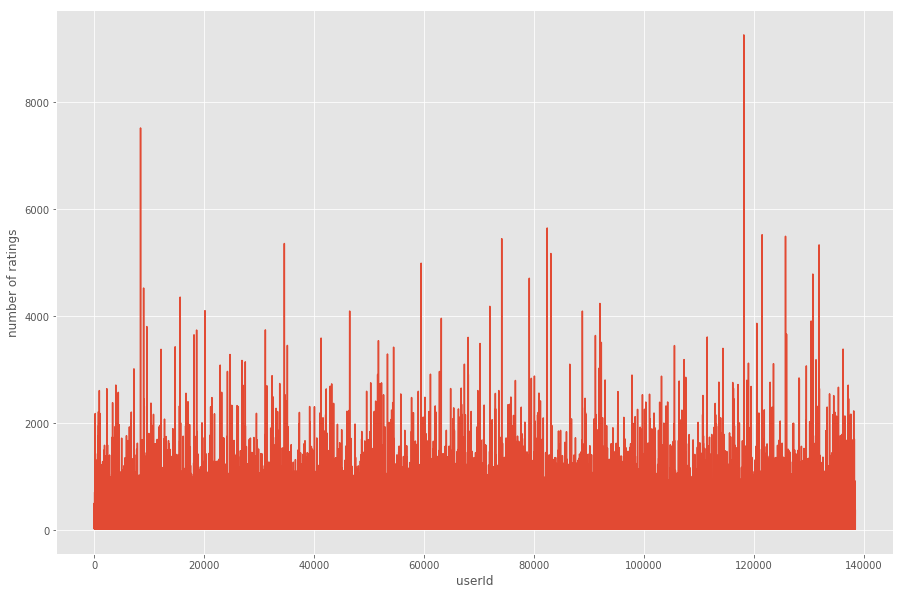

In [81]:
plt.plot(number_of_ratings_per_user)
plt.xlabel("userId")
plt.ylabel("number of ratings")

#### Plotting the number of ratings for each item (movie)

In [82]:
number_of_ratings_per_movie = collect_number_of_ratings('movieId')

Text(0, 0.5, 'number of ratings')

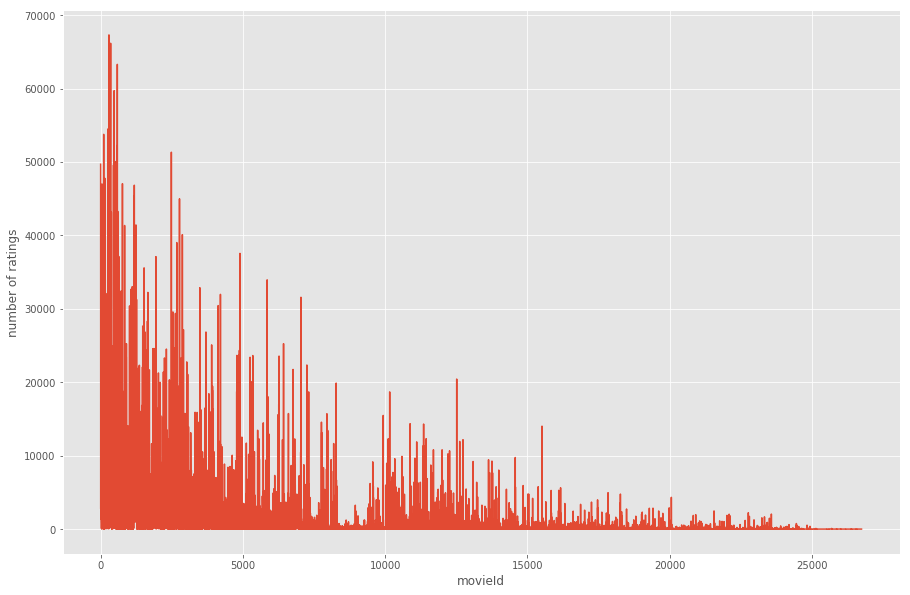

In [83]:
plt.plot(number_of_ratings_per_movie)
plt.xlabel("movieId")
plt.ylabel("number of ratings")


### Is the number of ratings balanced uniformly across users and movies?

In [84]:
def compute_stats(rdd):
    return round(np.mean(rdd),2), round(np.std(rdd),2),  round(np.median(rdd),2) 

def print_data(rdd, is_user_ratings=True):
    mean, std, median = compute_stats(rdd=rdd)
    if is_user_ratings:
        print("There is a total of {num_users} users.".format(num_users=len(rdd)))
        print("The average number of ratings per user is: {mean}, the standard deviation is: {std} and the median is: {median}".format(mean=mean, std=std, median=median))
    else:
        print("There is a total of {num_movies} movies.".format(num_movies=len(rdd)))
        print("The average number of ratings per movie is: {mean}, the standard deviation is: {std} and the median is: {median}".format(mean=mean, std=std, median=median))


In [85]:
print_data(number_of_ratings_per_user)
print_data(number_of_ratings_per_movie, False)

There is a total of 138493 users.
The average number of ratings per user is: 144.41, the standard deviation is: 230.27 and the median is: 68.0
There is a total of 26744 movies.
The average number of ratings per movie is: 747.84, the standard deviation is: 3085.76 and the median is: 18.0


Clearly there is a strong variance between different users, many have a little amount of ratings but there are exceptions as seen in the plot. In fact, a median as little as 68, compared to the mean, means there are only few users with a large amount of ratings, increasing the overall mean.

We can see an even stronger difference in the ratings of each item, where the range of the number of ratings is very variable, either having very few ratings or having a very large number of ratings. The median indicates there are many movies who have a large number of ratings, increasing both the mean and the standard deviation.

__As such, we can conclude that we are far from a uniform distribution in the number of ratings for both users and movies.__

In [86]:
!hdfs dfs -put my_ratings.txt

put: `my_ratings.txt': No such file or directory


We don't exactly know why it doesn't work even though the file does exist... but here are our personal ratings

In [87]:
my_ratings = sc.parallelize([{"movieId": 1, "userId": 138494, "timestamp": 1680785655, "rating": 3},
{"movieId": 1210, "userId": 138494, "timestamp": 1680785658, "rating": 5},
{"movieId": 648, "userId": 138494, "timestamp": 1680785661, "rating": 3},
{"movieId": 153, "userId": 138494, "timestamp": 1680785670, "rating": 4},
{"movieId": 597, "userId": 138494, "timestamp": 1680785672, "rating": 3},
{"movieId": 1580, "userId": 138494, "timestamp": 1680785675, "rating": 3}])

# This will simply extend the `data` RDD with the `additional` RDD.
new_data = data.union(my_ratings)
N = new_data.count()

In [88]:
training_data, validation_data = new_data.randomSplit([0.8, 0.2], seed=0)

## Baseline Recommendation Model

We start by computing the global average rating $\mu = \frac{1}{N}\sum\limits_{u,m}r_{um}$

In [89]:
global_avg_rating = training_data.map(lambda r : r["rating"]).sum()/training_data.count()

In [90]:
print(f"the global average rating is {round(global_avg_rating, 2)}")

the global average rating is 3.53


In the following cells, we calculate the total number of ratings per user and per movie, separately. Basically we create a dictionary associating userId to 1 then count by key (the number of times each user appears). This allows us to know how many ratings each user has.

In [91]:
ratings_per_user = training_data.map(lambda r: (r['userId'],1)).countByKey()

In [92]:
ratings_per_movie = training_data.map(lambda r: (r['movieId'],1)).countByKey()

Now we calculate $\alpha_u = \frac{1}{N_u}\sum\limits_{m}(r_{um}-\mu)$ and $\beta_m = \frac{1}{N_m}\sum\limits_u (r_{um}-\alpha_u - \mu)$

For $\alpha_u$ the idea is a little like the one above, we need to create tuples to use functions by Key. Basically,
we map the training data to tuples (userid, rating - global average) then sum all of the ratings - global average and finally we map a final time to divide by the number of ratings of the user. The last mapping produces a dictionary of tuples : (user, $1/N_u$ sum of rating-global average)

In [93]:
alpha = training_data.map(lambda rating: (rating['userId'], rating['rating']-global_avg_rating))\
            .reduceByKey(lambda a, b : a+b) \
            .map(lambda tup: (tup[0], tup[1]/ratings_per_user[tup[0]]))\
            .collect()

In [94]:
user_biases = dict(alpha)# this returns a dict of the form {user1: bias1, user2: bias2 ...}

We do the same thing for $\beta_m$ except now we use $\alpha_u$ so we just need to go fetch  the value from the user biases we created just above.

In [95]:
beta = training_data.map(lambda rating: (rating['movieId'], rating['rating'] - user_biases[rating['userId']] - global_avg_rating))\
                    .reduceByKey(lambda a, b: a + b)\
                    .map(lambda tup: (tup[0], tup[1]/ratings_per_movie[tup[0]]))\
                    .collect()

In [96]:
item_biases = dict(beta)

By default, we will set values for $\alpha_u$ and $\beta_m$ as 0 if users or movies have no ratings

In [97]:
def user_bias(user_id):
    try:
        return user_biases[user_id]
    except KeyError:
        return 0
    
def item_bias(movieId):
    try:
        return item_biases[movieId]
    except KeyError:
        return 0

The total number of parameters is the entirety of the biases, for users and movies, as well as the global average.

In [98]:
print(f"the model has {1 + len(user_biases) + len(item_biases)} parameters")

the model has 164379 parameters


In [99]:
def estimate_rating(user, movie):
    return round(global_avg_rating + user_bias(user) + item_bias(movie), 2)

In [100]:
estimated_ratings = validation_data.map(lambda r : {"movieId" : r["movieId"], "userId" : r["userId"], "estimated rating": estimate_rating(r["userId"], r["movieId"])})
estimated_ratings.take(10)

[{'movieId': 112, 'userId': 1, 'estimated rating': 3.65},
 {'movieId': 151, 'userId': 1, 'estimated rating': 3.75},
 {'movieId': 223, 'userId': 1, 'estimated rating': 4.04},
 {'movieId': 253, 'userId': 1, 'estimated rating': 3.7},
 {'movieId': 296, 'userId': 1, 'estimated rating': 4.28},
 {'movieId': 593, 'userId': 1, 'estimated rating': 4.28},
 {'movieId': 653, 'userId': 1, 'estimated rating': 3.45},
 {'movieId': 924, 'userId': 1, 'estimated rating': 4.08},
 {'movieId': 1036, 'userId': 1, 'estimated rating': 4.07},
 {'movieId': 1097, 'userId': 1, 'estimated rating': 3.89}]

In [101]:
validation_data.take(10)

[{'movieId': 112, 'userId': 1, 'timestamp': 1094785740, 'rating': 3.5},
 {'movieId': 151, 'userId': 1, 'timestamp': 1094785734, 'rating': 4.0},
 {'movieId': 223, 'userId': 1, 'timestamp': 1112485573, 'rating': 4.0},
 {'movieId': 253, 'userId': 1, 'timestamp': 1112484940, 'rating': 4.0},
 {'movieId': 296, 'userId': 1, 'timestamp': 1112484767, 'rating': 4.0},
 {'movieId': 593, 'userId': 1, 'timestamp': 1112484661, 'rating': 3.5},
 {'movieId': 653, 'userId': 1, 'timestamp': 1094785691, 'rating': 3.0},
 {'movieId': 924, 'userId': 1, 'timestamp': 1094785598, 'rating': 3.5},
 {'movieId': 1036, 'userId': 1, 'timestamp': 1112485480, 'rating': 4.0},
 {'movieId': 1097, 'userId': 1, 'timestamp': 1112485701, 'rating': 4.0}]

We can see the estimations are relatively accurate

## 3.8 Evaluation

In this section, we will calculate the error which is $\text{error} = \frac{1}{U}\sum\limits_u\sqrt{\frac{1}{N_u}\sum\limits_m(\hat r_{um}-r_{um})^2}$ where $U$ is the total number of users

In [102]:
U = len(user_biases) 
new_validation_data = validation_data\
                        .map(lambda x: ((x["userId"],x["movieId"]),x["rating"]))\

new_estimated_ratings = estimated_ratings\
                            .map(lambda x : ((x["userId"],x["movieId"]),x["estimated rating"]))

num_ratings_per_user_in_val = validation_data.map(lambda x: (x['userId'], x['rating'])).countByKey()

In [103]:
# Method which takes a prediction rdd and validation rdd, and outputs the RMSE error between the two
def error_func(rdd):
    # Map the rdds to the correct formats and join them    
    #this produces entries like: [(user, movie), (estimated, validation value)]
    error_ratings = rdd.join(new_validation_data).map(lambda x : (x[0][0], (x[1][0]-x[1][1])**2))
    # For each movie a user has watched, add the errors
    error_per_user = error_ratings.reduceByKey(lambda a,b: a + b).map(lambda x: (x[0], math.sqrt(x[1]/num_ratings_per_user_in_val[x[0]])))
    # Return the mean of what is left, i.e add all the values of the rdd and divide by the number of users
    sum = error_per_user.values().sum()
    return error_per_user.values().sum() / U

# We need the number of users in just the validation set


In [104]:
error_func(new_estimated_ratings)

0.8668998164029689

### 3.2.2 Matrix-factorization model

#### 3.9 regularization

In [105]:
from pyspark.mllib.recommendation import ALS

In [106]:
ratings = training_data.map(itemgetter("userId", "movieId", "rating"))

In [107]:
rank = 20
lambda_ = 1e-4
model = ALS.train(ratings=ratings, rank=rank, lambda_=lambda_)
validation = validation_data.map(itemgetter("userId", "movieId"))
prediction = model.predictAll(validation).map(lambda x: ((x[0], x[1]), x[2]))
error_lambda_1e_4 = error_func(prediction)
print(f"the error with lambda = {lambda_} is: {error_lambda_1e_4}")

the error with lambda = 0.0001 is: 1.089078039193706


Small $\lambda$ will not penalize overfitting a lot, so with $\lambda = 10^{-4}$, we will have a model that will overfit and hence, the predicted rating will not be really good and optimal

In [108]:
rank = 20
lambda_ = 10.
model = ALS.train(ratings=ratings, rank=rank, lambda_=lambda_)
validation = validation_data.map(itemgetter("userId", "movieId"))
prediction = model.predictAll(validation).map(lambda x: ((x[0], x[1]), x[2]))
error_lambda_10 = error_func(prediction)
print(f"the error with lambda = {lambda_} is: {error_lambda_10}")

the error with lambda = 10.0 is: 3.744692427174198


Big $\lambda$ (=10 in our case) will penalize more overfitting, and hence prevent it.
We can see this here, because the error function on the validation set is "huge"

this function looks for the best lambda give a list of lambda.
It will iterate over the list lambdas, compute the model and the prediction. 
It returns the best model and all the error.

In [109]:
def find_best_model(training_data, validation_data, lambdas, rank):
    errors = np.zeros(len(lambdas))
    best_model = None
    ratings = training_data.map(itemgetter("userId", "movieId", "rating"))
    validation = validation_data.map(itemgetter("userId", "movieId"))
    for i in range(len(lambdas)):
        lambda_ = lambdas[i]
        model = ALS.train(ratings=ratings, rank=rank, iterations=10, lambda_=lambda_)
        prediction = model.predictAll(validation).map(lambda x: ((x[0], x[1]), x[2]))
        error = error_func(prediction)
        if i == 0:
            best_model = model
        elif error < np.min(errors):
            best_model = model
        errors[i] = error
    return errors, best_model

In [112]:
rank = 20 #must be in [5, 25]
lambdas = [.01, 0.08, .1]
errors, best_model = find_best_model(training_data, validation_data, lambdas, rank)

In [113]:
i = np.argmin(errors)
best_lambda = lambdas[i]
smallest_error = errors[i]
print(f"The smallest error is with lambda = {best_lambda} and the error is : {smallest_error}")

The smallest error is with lambda = 0.08 and the error is : 0.7973488709729947


In [114]:
print(f"The improvement of error between lambda = 10 and lambda = 0.08 is {error_lambda_10 - smallest_error}")
print(f"The improvement of error between lambda = 1e-4 and lambda = 0.08 is {error_lambda_1e_4 - smallest_error}")


The improvement of error between lambda = 10 and lambda = 0.08 is 2.9473435562012034
The improvement of error between lambda = 1e-4 and lambda = 0.08 is 0.2917291682207114


#### 3.10 Recommandation

In [115]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie2name = dict(movies.map(itemgetter("movieId", "title")).collect())

given a user, a model and a num, this method will return de num first movies that user will most likely like. We do these computation according to the best model that we have found before

In [116]:
def recommended_movies(user, model, num=10):
    recommended_movies_for_user = model.recommendProducts(user, num)
    products_for_user = []
    for i in range(num):
        products_for_user.append(recommended_movies_for_user[i][1:])
    movies_for_user = [movie2name[product[0]] for product in products_for_user]
    for movie in movies_for_user:
        print(movie)


In [117]:
num=10
user=123
recommended_movies(user, best_model, num)
print(f"user {user} likes to watch dramas and comedies")

Apple, The (1980)
Radiohead: Meeting People Is Easy (1998)
Japon (a.k.a. Japan) (Japón) (2002)
Ito: A Diary of an Urban Priest (Seitti - kilvoittelijan päiväkirja) (2009)
Cabeza de Vaca (1991)
Jiminy Glick in La La Wood (2004)
Circus (2000)
South, The (Sur, El) (1983)
Pigsty (Porcile) (1969)
Oleanna (1994)
user 123 likes to watch dramas and comedies


In [118]:
user = 138494
recommended_movies(user, best_model, num)
print(f"user {user} mainly likes to watch comedies")

Beautiful Boy (2010)
Encounter in the Third Dimension (1999)
Björk: Volumen (1999)
House of 9 (2005)
Safe Sex (1999)
Star Is Born, A (1976)
Varasto (2011)
Absolon (2003)
Babyfever (1994)
Urban Ghost Story (1998)
user 138494 mainly likes to watch comedies


#### 3.11 Visualisation

In [119]:
# Read the .pickle file from the disk
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")
selected_movies

movie_IDs = [movie_info[0] for movie_info in selected_movies]

In [120]:
rank=2
ratings = training_data.map(itemgetter("userId", "movieId", "rating"))
model_with_rank_2 = ALS.train(ratings, rank=rank, lambda_= best_lambda)

In [121]:
feature_RDD = model_with_rank_2.userFeatures()

In [122]:
def filter_selected_movies(x):
    return x[0] in movie_IDs

In [123]:
selected_movies_features = list(feature_RDD.filter(filter_selected_movies).collect())

In [126]:
# Continuous colors
from matplotlib.colors import rgb2hex 
from bokeh.plotting import output_file
output_file('movies_selected.html')
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [movie[1][0] for movie in selected_movies_features],
        "y": [movie[1][1] for movie in selected_movies_features],
        "name": [movie2name[movie[0]] for movie in selected_movies_features]})

hover = HoverTool(
    tooltips=[
        ("Name", "@name")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=720, plot_height=720, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, alpha=0.5)
show(p, notebook_handle=True)



We don't have a great cinematographic culture, we will do our best not to say false things:

What we can say about the x-axis is that it gives us a certain idea of the "quality" of a film. Indeed, the more a movie is on the left side of the graph, the more likely it is to have been nominated/won a film award. This can be seen with Jurassic Park, Schindler's List or Brazil. All these movies have won Oscars.
On the contrary, the movies on the "right" side of the graph are mostly of lower quality (Schindler's List on the left is of better quality than Terminator on the right).
A "small" y means that the film is part of the drama genre, while a "big" y will mean a film that is more action-oriented

We can for example see a small cluster between "The city of god" and "the new york ripper", which are both movies that tell quite violent stories (one is about a young man and his best friend who form a gang that goes from robbery to murder to end up in drug trafficking, the other about a sadistic killer who preys on the female population of New York City, mutilating them in an atrocious way before killing them.)

There is an other cluster with spiderman, edge of tomorrow and Forrest Gump, but these films are not very alike